# Predictive Modeling for Agriculture

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

Our dataset, soil_measures, contains soil information and the optimal crop for that field. We will use this information to build a multi-class classification model to predict the ideal crop given soil conditions.

The soil_measures dataset contains:
- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"`: pH value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler

### Data Validation

We'll load and examine our dataset, check for missing values, and verify that feature columns are numeric.

There are 22 different crops:
- rice, maize, chickpea, kidneybeans, pigeonpeas, mothbeans, mungbean, blackgram, lentil, pomegranate, banana, mango, grapes, watermelon, muskmelon, apple, orange, papaya, coconut, cotton, jute, coffee

There are no missing values and all feature columns are numeric, concluding our data validation.

In [2]:
crops = pd.read_csv('datasets/soil_measures.csv') # 2200 x 5

print('There are', len(crops['crop'].unique()), 'unique crops.')

# The print statement below returns an empty dataframe, thus there are no missing values.
# print(crops[crops.isnull().any(axis=1)])
# crops_clean = crops.dropna()

# The print statement below returns the datatype of each column of crops.
# N, P, and K are int64 and ph is float64. Thus, all feature columsn are numeric.
# print(crops.dtypes)

print(crops.head())

There are 22 unique crops.
    N   P   K        ph  crop
0  90  42  43  6.502985  rice
1  85  58  41  7.038096  rice
2  60  55  44  7.840207  rice
3  74  35  40  6.980401  rice
4  78  42  42  7.628473  rice


The boxplot below shows a significant amount of outliers, primarily in levels of K, potassium. These values are for crops including grapes, with grapes thriving under conditions between 120 and 250 ppm of potassium. Thus, despite being outliers, these values of potassium concentration are expected.

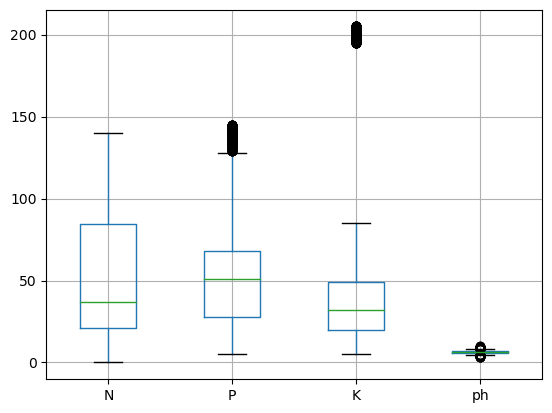

In [3]:
crops.boxplot()  
plt.show()
# print(crops[crops['K'] > 150])

### Train test split

We will split our 2200 row dataset into a training and test set, with 20% of values being reserved for testing.

In [4]:
y = crops[['crop']]
X = crops.drop(columns = 'crop')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

We will use multiclass logistic regression to predict ideal crops. To select the most significant features, we will fit a logistic regression and find an f1 score for each feature.

To reduce runtime, I scaled the feature data. This should not influence the F1 score but the K scores are significantly different.

In [5]:
# Scaled

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = ["N", "P", "K", "ph"])
X_test_scaled = pd.DataFrame(X_test_scaled, columns = ["N", "P", "K", "ph"])

y_train = column_or_1d(y_train, warn=True)

for feature in ["N", "P", "K", "ph"]:
    logistic_regression = LogisticRegression(max_iter = 2000, multi_class = 'multinomial')
    logistic_regression.fit(X_train_scaled[[feature]], y_train)
    print(feature, 'score:', f1_score(y_test, logistic_regression.predict(X_test_scaled[[feature]]), average = 'weighted'))

N score: 0.10689900116508289
P score: 0.08426955444720076
K score: 0.13831456375684123
ph score: 0.045464856528065166


C:\Users\Dan\AppData\Local\Temp\ipykernel_6976\1762607549.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_train = column_or_1d(y_train, warn=True)


In [6]:
# Not Scaled

for feature in ["N", "P", "K", "ph"]:
    logistic_regression = LogisticRegression(max_iter = 10000, multi_class = 'multinomial')
    logistic_regression.fit(X_train[[feature]], y_train)
    print(feature, 'score:', f1_score(y_test, logistic_regression.predict(X_test[[feature]]), average = 'weighted'))

N score: 0.10367653061010057
P score: 0.12816696343647532
K score: 0.21630633423610235
ph score: 0.04532731061152114


### Multicollinearity

There is debate as to whether we should include collinear features. 

If two variables are highly linearly related, including both rather than one does little to improve predictive power.
- Excluding one variable can cause strong confounding
- If we remove one collinear variable, we must note this in our analysis and interpretation, as it is impossible to know which or if both variables cause the observed effect in the responce variable

In [7]:
# Calculate the correlation matrix
crops_corr = crops[["N", "P", "K", "ph"]].corr()

crops_corr

,N,P,K,ph
N,1.000000,-0.231460,-0.140512,0.096683
P,-0.231460,1.000000,0.736232,-0.138019
K,-0.140512,0.736232,1.000000,-0.169503
ph,0.096683,-0.138019,-0.169503,1.000000


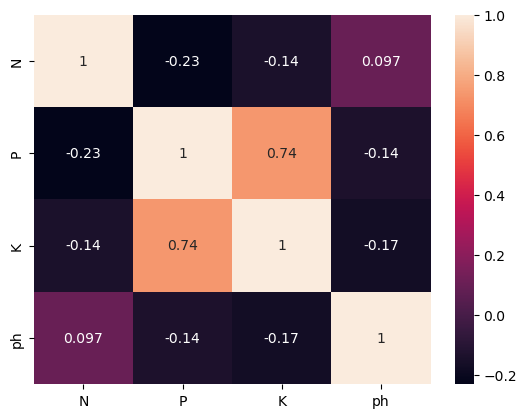

In [8]:
# Create a heatmap using seaborn
sns.heatmap(crops_corr, annot=True)
plt.show()

The heatmap above shows that K (Potassium) and P (Phosphorus) are significantly correlated. Therefore, we can remove one of these predictors and acheive similar accuracy. We will train and test new regression models with and without removing P.

### Logistic Regression - With and Without Phosphorus

In [9]:
# New Train Test Split

X_train_NoP, X_test_NoP, y_train_NoP, y_test_NoP = train_test_split(
    crops[["N", "K", "ph"]],
    crops["crop"],
    test_size=0.2,
    random_state=42
)

In [10]:
logistic_regression = LogisticRegression(max_iter = 20000, multi_class = 'multinomial')
logistic_regression.fit(X_train, y_train)
print('Default F1 Score:', f1_score(y_test, logistic_regression.predict(X_test), average = 'weighted'))

logistic_regression = LogisticRegression(max_iter = 20000, multi_class = 'multinomial', solver='saga')
logistic_regression.fit(X_train, y_train)
print('Default F1 Score with Saga Solver:', f1_score(y_test, logistic_regression.predict(X_test), average = 'weighted'))

logistic_regression = LogisticRegression(max_iter = 5000, multi_class = 'multinomial', solver='saga')
logistic_regression.fit(X_train_scaled, y_train)
print('Scaled F1 Score:', f1_score(y_test, logistic_regression.predict(X_test_scaled), average = 'weighted'))

logistic_regression = LogisticRegression(max_iter = 20000, multi_class = 'multinomial', solver='saga')
logistic_regression.fit(X_train_NoP, y_train_NoP)
print('Without Phosphorus F1 Score:', f1_score(y_test_NoP, logistic_regression.predict(X_test_NoP), average = 'weighted'))

D:\Python\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Default F1 Score: 0.6829512209861234
Default F1 Score with Saga Solver: 0.6086046112326493
Scaled F1 Score: 0.6475209891596989
Without Phosphorus F1 Score: 0.46542340778947433


### Conclusion

The model with the best F1 Score is the default model. This model uses the lbfgs solver and did not remove P or scale the features. However, this model fails to converge so we will focus on evaluating the models that converge.

Of the models that converge, the Scaled model performs the best. This model scaled the factors but did not drop P, implying that scaling the factors improved precision and or recall.

The model that dropped Phosphorus performed the worst. While dropping collinear factors can help a model converge, doing so can lead to issues interpretting the model and worsen model performance. Thus, it is unnecessary to drop Phosphorus from this analysis.

- We conclude that scaling factors can significantly improve model performance and dropping collinear factors can significantly hinder model performance.